
# Retail revenue & profit trends (Linear Regression)



## Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Sử dụng đường dẫn tương đối để code linh hoạt hơn
DATA_PATH = Path("../[DATASET C] Retail Supply Chain Sales Analysis/[C] Retail-Supply-Chain-Sales-Analysis.xlsx")

data_path = DATA_PATH


## Load data


In [2]:

retail = pd.read_excel(data_path, sheet_name='Retails Order Full Dataset')
calendar = pd.read_excel(data_path, sheet_name='Calendar Table')

# Ensure datetime types
retail['Order Date'] = pd.to_datetime(retail['Order Date'])
retail['Ship Date'] = pd.to_datetime(retail['Ship Date'])
calendar['Date'] = pd.to_datetime(calendar['Date'])

retail.head(), calendar.head()


(   Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
 0       1  CA-2016-152156 2016-08-11 2016-11-11    Second Class    CG-12520   
 1       2  CA-2016-152156 2016-08-11 2016-11-11    Second Class    CG-12520   
 2       3  CA-2016-138688 2016-12-06 2016-12-06    Second Class    DV-13045   
 3       4  US-2015-108966 2015-11-10 2015-11-10  Standard Class    SO-20335   
 4       5  US-2015-108966 2015-11-10 2015-11-10  Standard Class    SO-20335   
 
      Customer Name    Segment        Country             City  ...  \
 0      Claire Gute   Consumer  United States        Henderson  ...   
 1      Claire Gute   Consumer  United States        Henderson  ...   
 2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
 3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
 4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
 
   Retail Sales People       Product ID         Category Sub-Category  \
 0   Cassandra Br

## Aggregate revenue/profit over time


In [3]:
# Monthly buckets
retail_monthly = retail.assign(
    order_month=retail['Order Date'].dt.to_period('M').dt.to_timestamp()
).groupby('order_month', as_index=False)[['Sales', 'Profit']].sum()

# Keep chronological order and index to use as numeric time feature
retail_monthly = retail_monthly.sort_values('order_month').reset_index(drop=True)
retail_monthly['period_index'] = retail_monthly.index  

retail_monthly.head()

,order_month,Sales,Profit,period_index
0,2014-01-01,28953.706,4549.4546,0
1,2014-02-01,12743.108,2654.5569,1
2,2014-03-01,54801.906,92.6990,2
3,2014-04-01,24710.016,4601.0714,3
4,2014-05-01,29639.834,3912.2499,4



## Linear trend models
Fit Linear Regression of Sales/Profit vs time index to quantify average monthly change and derive a trend line.

In [4]:
def fit_linear_trend(df, target_col, index_col='period_index'):
    X = df[[index_col]]
    y = df[target_col]
    model = LinearRegression()
    model.fit(X, y)
    trend = model.predict(X)
    r2 = model.score(X, y)
    coef = float(model.coef_[0])
    intercept = float(model.intercept_)
    out = df.copy()
    out[f'{target_col}_trend'] = trend
    return out, coef, intercept, r2

sales_trend, sales_coef, sales_intercept, sales_r2 = fit_linear_trend(retail_monthly, 'Sales')
profit_trend, profit_coef, profit_intercept, profit_r2 = fit_linear_trend(retail_monthly, 'Profit')

print('Sales trend: slope = {:.2f} per month, R^2 = {:.3f}'.format(sales_coef, sales_r2))
print('Profit trend: slope = {:.2f} per month, R^2 = {:.3f}'.format(profit_coef, profit_r2))


Sales trend: slope = 719.12 per month, R^2 = 0.355
Profit trend: slope = 107.37 per month, R^2 = 0.123



## Visualize trends
Actual monthly totals vs fitted linear trend lines for quick eyeballing of growth/decline and any outliers.


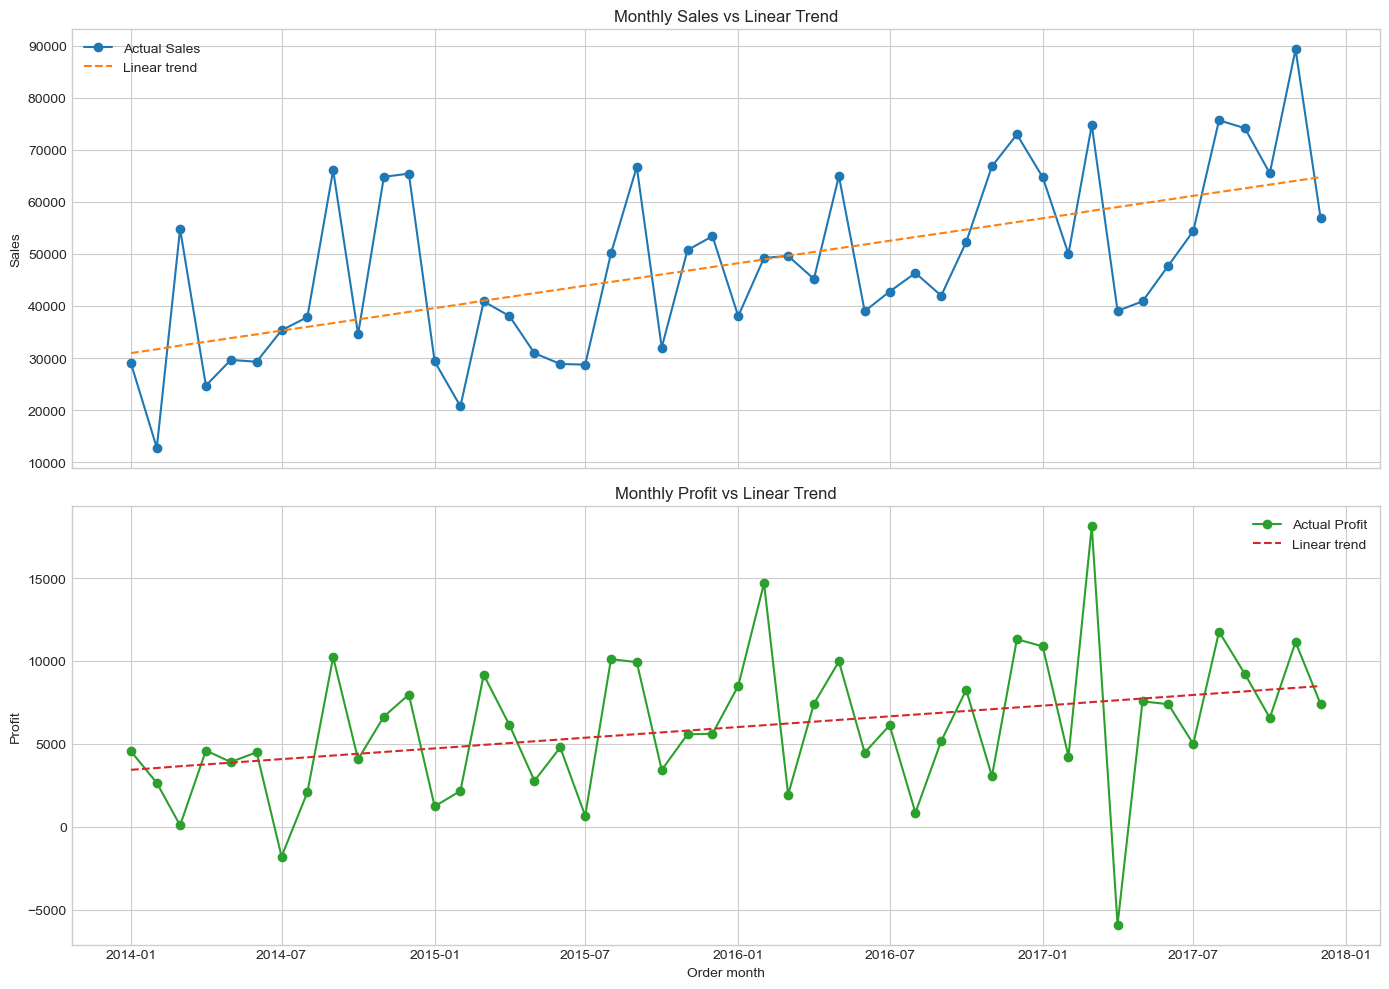

In [5]:

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axes[0].plot(sales_trend['order_month'], sales_trend['Sales'], label='Actual Sales', marker='o')
axes[0].plot(sales_trend['order_month'], sales_trend['Sales_trend'], label='Linear trend', linestyle='--')
axes[0].set_ylabel('Sales')
axes[0].set_title('Monthly Sales vs Linear Trend')
axes[0].legend()

axes[1].plot(profit_trend['order_month'], profit_trend['Profit'], label='Actual Profit', marker='o', color='tab:green')
axes[1].plot(profit_trend['order_month'], profit_trend['Profit_trend'], label='Linear trend', linestyle='--', color='tab:red')
axes[1].set_ylabel('Profit')
axes[1].set_title('Monthly Profit vs Linear Trend')
axes[1].legend()

plt.xlabel('Order month')
plt.tight_layout()
plt.show()


## Quarterly summary (optional)
Quick pivot to compare periods and spot jumps/dips.

In [6]:

retail_quarterly = retail.assign(
    order_quarter=retail['Order Date'].dt.to_period('Q').dt.to_timestamp()
).groupby('order_quarter', as_index=False)[['Sales', 'Profit']].sum()
retail_quarterly


,order_quarter,Sales,Profit
0,2014-01-01,96498.7200,7296.7105
1,2014-04-01,83636.8806,13013.0659
2,2014-07-01,139306.0173,10529.9877
3,2014-10-01,164805.8802,18704.2100
4,2015-01-01,90952.3496,12574.1468
5,2015-04-01,97852.8812,13700.7278
6,2015-07-01,145554.2330,20713.3740
7,2015-10-01,136173.0452,14630.3551
8,2016-01-01,136898.6390,25135.2338
9,2016-04-01,149148.5428,21878.9847


## Quarter/year aggregation with linear trends
Repeat the trend check at quarterly and yearly granularity to reduce noise and compare medium/long-term growth.


In [7]:
def summarize_trend(freq_label, freq_code):
    agg = retail.assign(
        period=retail['Order Date'].dt.to_period(freq_code).dt.to_timestamp()
    ).groupby('period', as_index=False)[['Sales', 'Profit']].sum()
    agg = agg.sort_values('period').reset_index(drop=True)
    agg['period_index'] = agg.index

    sales_t, s_coef, _, s_r2 = fit_linear_trend(agg, 'Sales')
    profit_t, p_coef, _, p_r2 = fit_linear_trend(agg, 'Profit')

    print(f"{freq_label} sales slope = {s_coef:,.2f} per period, R^2 = {s_r2:.3f}")
    print(f"{freq_label} profit slope = {p_coef:,.2f} per period, R^2 = {p_r2:.3f}")
    return sales_t, profit_t

sales_q, profit_q = summarize_trend('Quarterly', 'Q')
sales_y, profit_y = summarize_trend('Yearly', 'Y')

Quarterly sales slope = 6,289.69 per period, R^2 = 0.550
Quarterly profit slope = 923.03 per period, R^2 = 0.357
Yearly sales slope = 88,557.64 per period, R^2 = 0.865
Yearly profit slope = 15,186.25 per period, R^2 = 0.988



## 8) Train/test split and 6-month projection (monthly)
Chronological 80/20 split to evaluate the simple trend model, then forecast the next 6 months.

In [8]:

from sklearn.metrics import mean_absolute_error, mean_squared_error

n_train = int(len(retail_monthly) * 0.8)
X_full = retail_monthly[['period_index']]


def fit_forecast(target_series, label, future_periods=6):
    y = target_series
    X_train, X_test = X_full.iloc[:n_train], X_full.iloc[n_train:]
    y_train, y_test = y.iloc[:n_train], y.iloc[n_train:]

    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test.values) # Sử dụng .values để tránh UserWarning
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Cập nhật để tránh FutureWarning

    future_index = np.arange(len(X_full), len(X_full) + future_periods)
    future_dates = pd.date_range(
        retail_monthly['order_month'].max() + pd.offsets.MonthBegin(1),
        periods=future_periods,
        freq='MS'
    )
    future_pred = model.predict(future_index.reshape(-1, 1)) # Sử dụng .values để tránh UserWarning
    forecast = pd.DataFrame({
        'order_month': future_dates,
        f'{label}_forecast': future_pred
    })
    return {
        'mae': mae,
        'rmse': rmse,
        'model': model,
        'forecast': forecast,
        'y_pred_test': y_pred,
        'y_test': y_test
    }

sales_eval = fit_forecast(retail_monthly['Sales'], 'sales')
profit_eval = fit_forecast(retail_monthly['Profit'], 'profit')

print(f"Sales MAE={sales_eval['mae']:,.0f}, RMSE={sales_eval['rmse']:,.0f}")
print(f"Profit MAE={profit_eval['mae']:,.0f}, RMSE={profit_eval['rmse']:,.0f}")

print('Sales 6-month forecast:')
print(sales_eval['forecast'])

print('Profit 6-month forecast:')
print(profit_eval['forecast'])


Sales MAE=13,569, RMSE=15,162
Profit MAE=3,845, RMSE=5,762
Sales 6-month forecast:
  order_month  sales_forecast
0  2018-01-01    63930.102820
1  2018-02-01    64599.694703
2  2018-03-01    65269.286587
3  2018-04-01    65938.878471
4  2018-05-01    66608.470355
5  2018-06-01    67278.062238
Profit 6-month forecast:
  order_month  profit_forecast
0  2018-01-01      8874.569999
1  2018-02-01      8989.781882
2  2018-03-01      9104.993765
3  2018-04-01      9220.205648
4  2018-05-01      9335.417531
5  2018-06-01      9450.629414



## 9) Residual-based anomaly detection (monthly)
Flag months where actuals deviate strongly from the fitted linear trend using Z-score on residuals.


Sales anomalies:
Empty DataFrame
Columns: [order_month, Sales, Sales_trend, residual, Z-score]
Index: []
Profit anomalies:
   order_month      Profit  Profit_trend      residual  Z-score
38  2017-03-01  18127.8605   7523.463296  10604.397204  2.66547
39  2017-04-01  -5890.0374   7630.832860 -13520.870260  3.39854


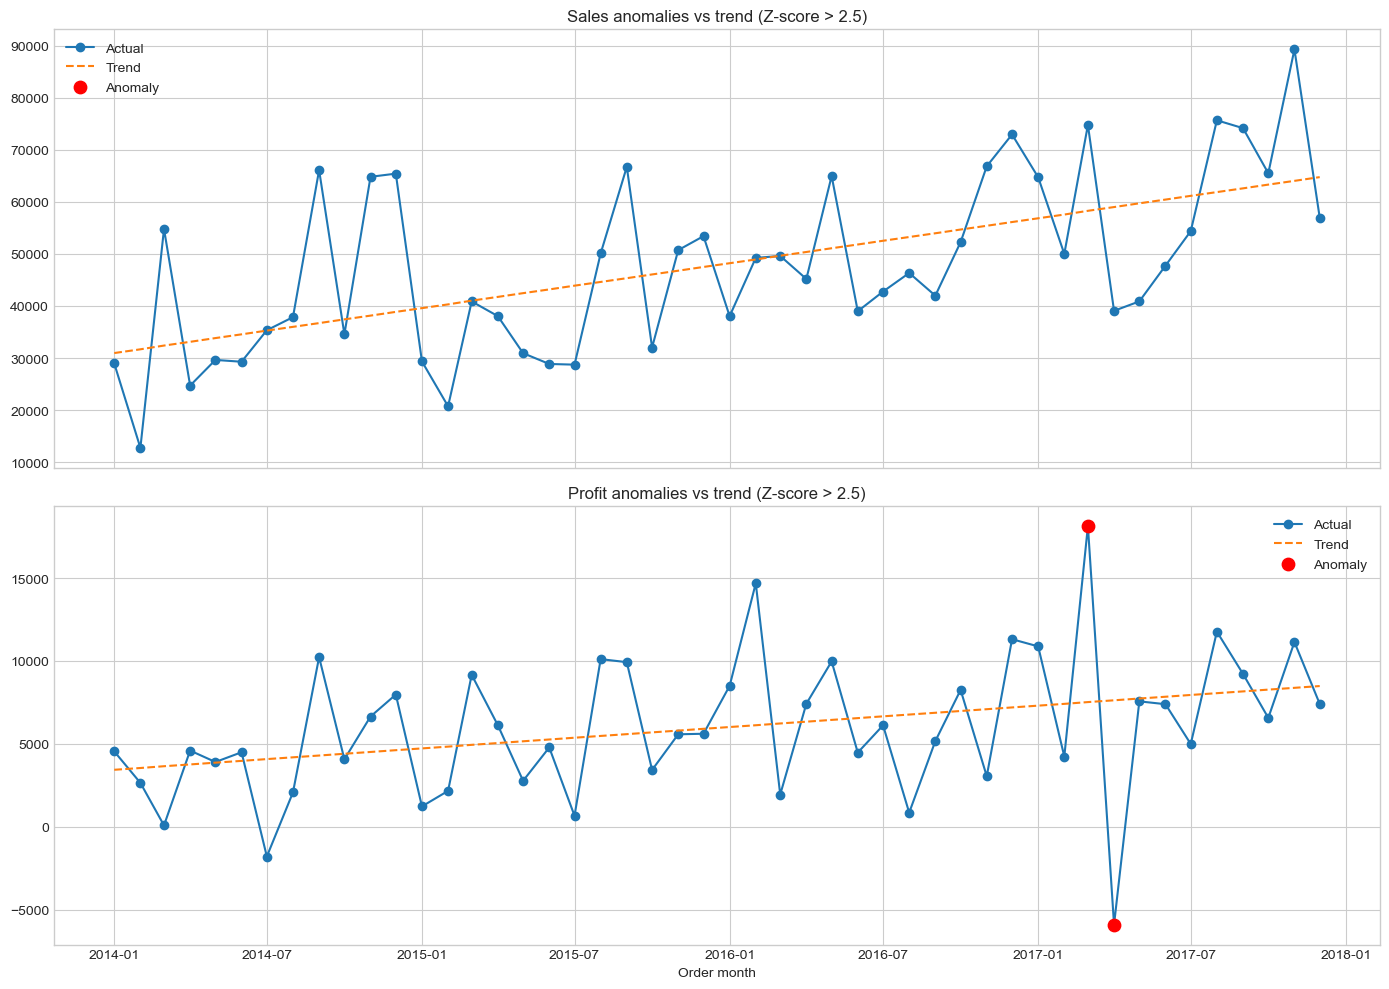

In [9]:

def flag_anomalies(trend_df, target_col, trend_col, Z_thresh=2.5):
    residuals = trend_df[target_col] - trend_df[trend_col]
    Z = (residuals - residuals.mean()).abs() / (residuals.std(ddof=0) + 1e-9)
    flagged = trend_df.copy()
    flagged['residual'] = residuals
    flagged['Z-score'] = Z
    flagged['anomaly'] = Z > Z_thresh
    return flagged

sales_anoms = flag_anomalies(sales_trend, 'Sales', 'Sales_trend')
profit_anoms = flag_anomalies(profit_trend, 'Profit', 'Profit_trend')

print('Sales anomalies:')
print(sales_anoms[sales_anoms['anomaly']][['order_month', 'Sales', 'Sales_trend', 'residual', 'Z-score']])
print('Profit anomalies:')
print(profit_anoms[profit_anoms['anomaly']][['order_month', 'Profit', 'Profit_trend', 'residual', 'Z-score']])

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
for ax, anoms, target, trend in [
    (axes[0], sales_anoms, 'Sales', 'Sales_trend'),
    (axes[1], profit_anoms, 'Profit', 'Profit_trend')
]:
    ax.plot(anoms['order_month'], anoms[target], label='Actual', marker='o')
    ax.plot(anoms['order_month'], anoms[trend], label='Trend', linestyle='--')
    flagged = anoms[anoms['anomaly']]
    ax.scatter(flagged['order_month'], flagged[target], color='red', s=80, zorder=5, label='Anomaly')
    ax.set_title(f"{target} anomalies vs trend (Z-score > 2.5)")
    ax.legend()

plt.xlabel('Order month')
plt.tight_layout()
plt.show()